## Load Modules

In [17]:
# Jupyter Notebook with widget matplotlib plots
%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
# %matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from ipdb import set_trace as mybreak
import pyicon as pyic
import cartopy.crs as ccrs
import glob
import pickle
import maps_icon_smt_temp as smt
import datetime
from matplotlib.patches import Rectangle
import xarray as xr

from icon_smt_levels import dzw, dzt, depthc, depthi

## configure paths

In [19]:
run      = 'ngSMT_tke'
savefig  = False
path_fig = '../pics/'
nnf      = 0

gname = 'smt'
lev   = 'L128'

path_data    = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/????-??/'
#fpath_tgrid = '/mnt/lustre01/work/mh0287/users/leonidas/icon/submeso/grid/cell_grid-OceanOnly_SubmesoNA_2500m_srtm30-icon.nc'
fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'
fpath_Tri    = '/mnt/lustre01/work/mh0033/m300602/tmp/Tri.pkl'

path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree  = f'{path_grid}ckdtree/'
# fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'
fpath_ckdtree = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'

In [20]:
mfdset_kwargs = dict(combine='nested', concat_dim='time', 
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                     parallel=True,
                    )

### filenames
- h: SSH 
- T: Temp.
- S: salinity
- vn: velocity normal to triangle edges (auf edges definiert, nicht gut zum Plotten geeignet)
- vort_f_50m: vorticity devided by f (Coriolis parameter) at 50m


In [21]:
grid_sphere_radius = 6.371229e6

## Remap Velocities

### read out grid data

In [22]:
%%time
f = Dataset(fpath_tgrid, 'r')
clon = f.variables['clon'][:] * 180./np.pi # center longitude
clat = f.variables['clat'][:] * 180./np.pi # center latitude
vlon = f.variables['vlon'][:] * 180./np.pi # vertex longitude
vlat = f.variables['vlat'][:] * 180./np.pi # vertex latitude
vertex_of_cell = f.variables['vertex_of_cell'][:].transpose()-1 # vertices of each cellcells ad
edge_of_cell = f.variables['edge_of_cell'][:].transpose()-1 # edges of each cellvertices
edges_of_vertex = f.variables['edges_of_vertex'][:].transpose()-1 # edges around vertex
dual_edge_length = f.variables['dual_edge_length'][:] # lengths of dual edges (distances between triangul 
edge_orientation = f.variables['edge_orientation'][:].transpose()
edge_length = f.variables['edge_length'][:] # lengths of edges of triangular cells
cell_area_p = f.variables['cell_area_p'][:] # area of grid cell 
dual_area = f.variables['dual_area'][:] # areas of dual hexagonal/pentagonal cells
#edge_length = f.variables['edge_length'][:]
adjacent_cell_of_edge = f.variables['adjacent_cell_of_edge'][:].transpose()-1 # cells adjacent to each edge 
orientation_of_normal = f.variables['orientation_of_normal'][:].transpose() # orientations of normals to triangular cell edges
edge_vertices = f.variables['edge_vertices'][:].transpose()-1 #vertices at the end of of each edge
f.close()

CPU times: user 4.25 s, sys: 17.1 s, total: 21.4 s
Wall time: 23.1 s


In [23]:
%%time
dtype = 'float32'
f = Dataset(fpath_tgrid, 'r')
elon = f.variables['elon'][:] * 180./np.pi #edge midpoint longitude
elat = f.variables['elat'][:] * 180./np.pi #edge midpoint latitude
cell_cart_vec = np.ma.zeros((clon.size,3), dtype=dtype)
cell_cart_vec[:,0] = f.variables['cell_circumcenter_cartesian_x'][:] # cartesian position of the prime cell circumcenter
cell_cart_vec[:,1] = f.variables['cell_circumcenter_cartesian_y'][:]
cell_cart_vec[:,2] = f.variables['cell_circumcenter_cartesian_z'][:]
edge_cart_vec = np.ma.zeros((elon.size,3), dtype=dtype)
edge_cart_vec[:,0] = f.variables['edge_middle_cartesian_x'][:] # prime edge center cartesian coordinate x on unit
edge_cart_vec[:,1] = f.variables['edge_middle_cartesian_y'][:]
edge_cart_vec[:,2] = f.variables['edge_middle_cartesian_z'][:]
f.close()

CPU times: user 3.89 s, sys: 10.8 s, total: 14.7 s
Wall time: 15.5 s


In [24]:
%%time
dist_vector        = edge_cart_vec[edge_of_cell,:] - cell_cart_vec[:,np.newaxis,:]
norm               = np.sqrt(pyic.scalar_product(dist_vector,dist_vector,dim=2))
prime_edge_length  = edge_length/grid_sphere_radius
fixed_vol_norm     = (0.5 * norm * (prime_edge_length[edge_of_cell]))
fixed_vol_norm     = fixed_vol_norm.sum(axis=1)
edge2cell_coeff_cc = (dist_vector * (edge_length[edge_of_cell,np.newaxis] / grid_sphere_radius) * orientation_of_normal[:,:,np.newaxis] )

CPU times: user 25.7 s, sys: 13.7 s, total: 39.4 s
Wall time: 40.5 s


In [25]:
edge_length

masked_array(data=[ 862.74524419,  862.7490261 ,  862.78615485, ...,
                   1822.85854464, 1763.93171169, 2005.34785185],
             mask=False,
       fill_value=1e+20)

### load velocity normal to triangle edges

In [26]:
# --- load times and flist
time0 = np.datetime64('2010-03-09T01:00:00')
# search_str = f'{run}_T_S_sp_001-016_*.nc'
search_str = f'{run}_vn_sp_001-016_*.nc' # velocity files
# search_str = f'{run}_vn_sp_081-096_*.nc'
flist = np.array(glob.glob(path_data+search_str))
flist.sort()
timesd, flist_tsd, itsd = pyic.get_timesteps(flist, time_mode='float2date')
###
itd = np.argmin((timesd-time0).astype(float)**2)
fpath = flist_tsd[itd]
f = Dataset(fpath, 'r')

depth0 = 52.  # needs to suite dataset
iz = np.argmin((depthc-depth0)**2)
#choose real hight
# Choose data variable
var = f'vn{iz:03d}_sp'
# var = 'vn001_sp'
# var = 'vn090_sp'
#var = 'vn016_sp' 

ve = f.variables[var][itsd[itd],:] # VELOCITies on edges # choosen timestep itd # choosen var
f.close()
print(timesd[itd], var)

2010-03-09T01:00:00 vn016_sp


In [27]:
flist

array(['/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_vn_sp_001-016_20100109T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_vn_sp_001-016_20100110T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_vn_sp_001-016_20100111T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_vn_sp_001-016_20100112T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_vn_sp_001-016_20100113T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_vn_sp_001-016_20100114T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_vn_sp_001-016_20100115T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_vn_sp_001-016_20100116T010000Z.nc',
       '/mnt/lustre01/wo

In [28]:
ve.shape

(89813639,)

In [29]:
#depth # it does not have any effect? needs to be changed
#depth0 = 50.
#iz = (depthc<depth0).sum()
#iz, depthc[iz]

In [30]:
# depth0 = 52.
# iz = np.argmin((depthc-depth0)**2)
# iz

### velocity normal in cell center - full

In [31]:
%%time
p_vn_c = ( edge2cell_coeff_cc[:,:,:]
         * ve[edge_of_cell,np.newaxis]
#          * prism_thick_e[iz,IcD.edge_of_cell,np.newaxis]
         * dzw[iz]
       ).sum(axis=1)
p_vn_c *= 1./(fixed_vol_norm[:,np.newaxis]*dzw[iz])

CPU times: user 26.1 s, sys: 6.77 s, total: 32.8 s
Wall time: 32.9 s


In [32]:
p_vn_c.shape

(59799625, 3)

In [33]:
%%time
sinLon = np.sin(clon*np.pi/180.)
cosLon = np.cos(clon*np.pi/180.)
sinLat = np.sin(clat*np.pi/180.)
cosLat = np.cos(clat*np.pi/180.)

u1 = p_vn_c[:,0]
u2 = p_vn_c[:,1]
u3 = p_vn_c[:,2]

uo =   u2*cosLon - u1*sinLon
vo = -(u1*cosLon + u2*sinLon)*sinLat + u3*cosLat

CPU times: user 9.55 s, sys: 6.96 s, total: 16.5 s
Wall time: 16.5 s


In [34]:
uo.size

59799625

### interpolate to rectangular grid - selection

In [35]:
# --- interpolate to rectgrid
ddnpz = np.load(fpath_ckdtree)
lon_002deg = ddnpz['lon']
lat_002deg = ddnpz['lat']
#ro_002deg = pyic.apply_ckdtree(ro, fpath_ckdtree, coordinates='clat clon', radius_of_influence=1.).reshape(lat_002deg.size, lon_002deg.size)
#ro_002deg[ro_002deg==0.] = np.ma.masked

In [36]:
lon_reg_2 = [-75, -55]
lat_reg_2 = [33, 43]

# --- cut domain 2
i1r2 = (lon_002deg<lon_reg_2[0]).sum()
i2r2 = (lon_002deg<lon_reg_2[1]).sum()
j1r2 = (lat_002deg<lat_reg_2[0]).sum()
j2r2 = (lat_002deg<lat_reg_2[1]).sum()

lon_002deg_r2 = lon_002deg[i1r2:i2r2]
lat_002deg_r2 = lat_002deg[j1r2:j2r2]
#ro_002deg_r2= ro_002deg[j1r2:j2r2,i1r2:i2r2]

In [37]:
uo_002deg = pyic.apply_ckdtree(uo, fpath_ckdtree, coordinates='clat clon', radius_of_influence=1.).reshape(lat_002deg.size, lon_002deg.size)
uo_002deg[uo_002deg==0.] = np.ma.masked
uo_002deg_r2= uo_002deg[j1r2:j2r2,i1r2:i2r2]

vo_002deg = pyic.apply_ckdtree(vo, fpath_ckdtree, coordinates='clat clon', radius_of_influence=1.).reshape(lat_002deg.size, lon_002deg.size)
vo_002deg[vo_002deg==0.] = np.ma.masked
vo_002deg_r2= vo_002deg[j1r2:j2r2,i1r2:i2r2]

### velocity plot

<IPython.core.display.Javascript object>


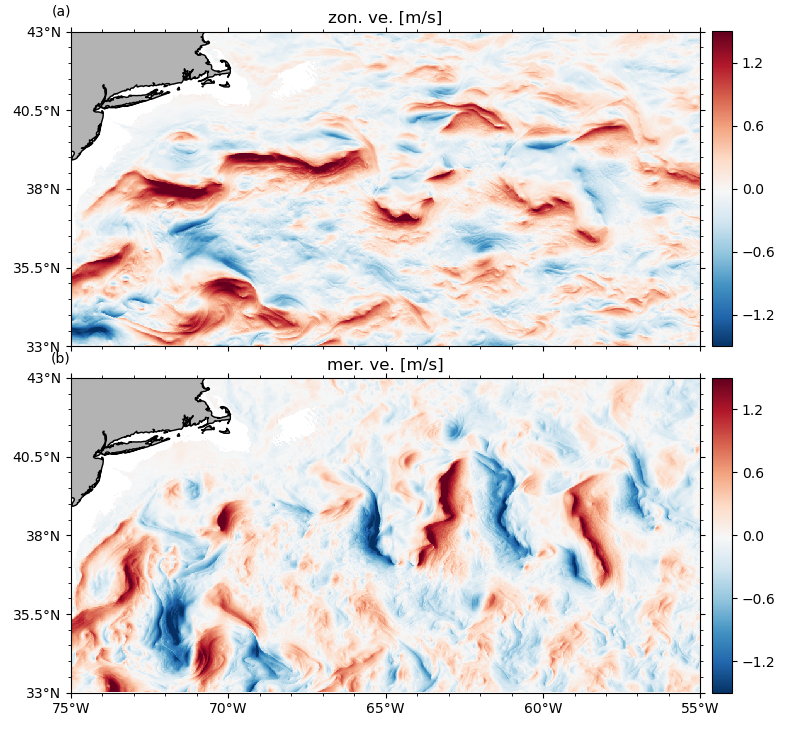

In [38]:
ccrs_proj = ccrs.PlateCarree()
# ccrs_proj = None
hca, hcb = pyic.arrange_axes(1, 2, plot_cb=True, asp=0.5, projection=ccrs_proj, fig_size_fac=2)
ii=-1
clim = 1.5

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm2 = pyic.shade(lon_002deg_r2, lat_002deg_r2, uo_002deg_r2, ax=ax, cax=cax, clim=clim,
                transform=ccrs_proj, rasterized=False)
ax.set_title('zon. ve. [m/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm2 = pyic.shade(lon_002deg_r2, lat_002deg_r2, vo_002deg_r2, ax=ax, cax=cax, clim=clim,
                transform=ccrs_proj, rasterized=False)
ax.set_title('mer. ve. [m/s]')

#ii+=1; ax=hca[ii]; cax=hcb[ii]
#hm2 = pyic.shade(lon_002deg_r2, lat_002deg_r2, ke_002deg_r2, ax=ax, cax=cax, clim=[0,1],
#                transform=ccrs_proj, rasterized=False)
#ax.set_title('kin. energy [m$^2$/s$^2$]')

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg_2, ylim=lat_reg_2)
# savefig('dissipation', format='png')

## Calc Divergence

In [39]:
# calculate divergence
div_coeff = (  edge_length[edge_of_cell]*orientation_of_normal ) / cell_area_p[:,np.newaxis]
div_v     = (ve[edge_of_cell]    * div_coeff).sum(axis=1)


In [40]:
div_v.size

59799625

In [41]:
div_coeff.size

179398875

In [42]:
#nc = int(div_coeff.size/3)
#nc

In [43]:
path_data

'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/????-??/'

In [44]:
edge_of_cell.size

179398875

##############################################################
### Save Data

In [36]:
# does not work from jupyter
levs = np.arange(depthc.size)
nz = levs.size
depthc = depthc[levs]

nc = p_vn_c.size #clon_reg.siz~

fpatho = '~/pp_calc_div2.nc'
fpatho = '/mnt/lustre01/pf/zmaw/u241317/notebooks/smt'
#path_data = '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/'
fo = Dataset(fpatho, 'w')
#fo.createDimension('jc', nc)
fo.createDimension('depthc', nz) # depth
fo.createDimension('div_v', div_v.size) # depth

ncv = fo.createVariable('depthc','f4',('depthc',))
ncv[:] = depthc[:nz]

nc_div = fo.createVariable('div_v','f4',('div_v',))
nc_div[:] = div_v[:] #p_vn_c[:nc]

# fo.createDimension('T', t00.size)
# nc_T = fo.createVariable('T','f4',('T',))
# nc_T[:] = t00[:t00.size]

fo.close()

PermissionError: [Errno 13] Permission denied: b'/mnt/lustre01/pf/zmaw/u241317/notebooks/smt'

In [ ]:
nc_div

In [ ]:
fpatho = '/scratch/u/u241317/calc/pp_calc_div.nc'
print ('saving to ', fpatho)
xdiv_v = xr.DataArray(div_v)
xdiv_v.to_netcdf(path=fpatho)
print ('finished saving')

In [ ]:
xdiv_v

In [ ]:
div_v

## Plot Divergence

<IPython.core.display.Javascript object>


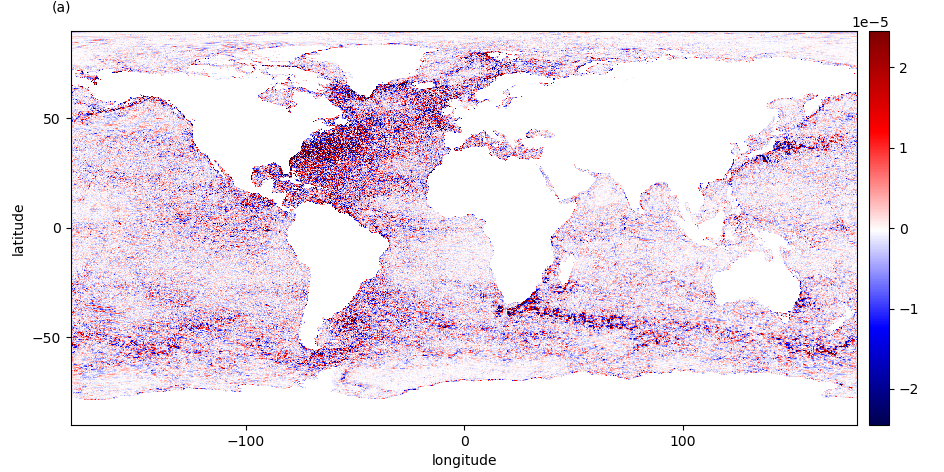

NameError: name 'IcD' is not defined

In [45]:
### Plot vertical heat flux
#Rectangular Grid
fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'
lon, lat, toi = pyic.interp_to_rectgrid(div_v, fpath_ckdtree, coordinates='clat clon');

#adjust colorbar to 0 and emphazise coloring
a=0.1
if abs(toi.min()) < abs(toi.max()) :
    tm = abs(toi.min())
else :
    tm = abs(toi.max())

hca, hcb = pyic.arrange_axes(1,1, plot_cb=True, asp=0.5, fig_size_fac=2.5)
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, cmap='seismic', clim=(-a*tm,a*tm))#clim='sym'
#colors.TwoSlopeNorm(vcenter=0)  ,norm=MidpointNormalize(midpoint=0. clim=(a*toi.min(),a*toi.max())
#colors.TwoSlopeNorm(vmin=-5., vcenter=0., vmax=10)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('temperature * vert. velocity at %s and %.1fm depth'%(IcD.times[it], IcD.depthc[iz]))
cax.set_title('$^o$C')
#colors.TwoSlopeNorm(vmin=-5., vcenter=0., vmax=10)

In [47]:
levs = np.array([1,2,3,4,5])
levs

array([1, 2, 3, 4, 5])

In [44]:
levs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111])

In [38]:
# --- load times and flist
time0 = np.datetime64('2010-03-09T01:00:00')
#ts = pyic.timing(ts, 'load times and flist')
search_str = f'{run}_vn_sp_001-016_*.nc' # only to get time data
flist = np.array(glob.glob(path_data+search_str))
flist.sort()
timesd, flist_tsd, itsd = pyic.get_timesteps(flist, time_mode='float2date')

itd = np.argmin((timesd-time0).astype(float)**2)
fpath = flist_tsd[itd]
#pdtime0 = pd.to_datetime(time0) 
#tstr = pdtime0.strftime('%Y%m%d')+'T010000Z'

In [35]:
fpath

'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/ngSMT_tke_vn_sp_001-016_20100309T010000Z.nc'

In [42]:
#####################################################################
### Calculate DIvergence of multiple layers
levs = np.arange(depthc.size)
nz = levs.size
depthc = depthc[levs]

div_coeff = (  edge_length[edge_of_cell]*orientation_of_normal ) / cell_area_p[:,np.newaxis]
jc = int(div_coeff.size/3)

fpatho = '/scratch/u/u241317/calc/pp_calc_m_div.nc'
#path_data = '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/'
fo = Dataset(fpatho, 'w')
fo.createDimension('depthc', nz) # depth
fo.createDimension('div_v', jc) # new dim

ncv = fo.createVariable('depthc','f4',('depthc',))
ncv[:] = depthc[:nz]

# nc_div = fo.createVariable('div_v','f4',('depthc','jc',))
# nc_div[:] = div_v[:] #p_vn_c[:nc]

nc_div = fo.createVariable('div_v','f4',('depthc','div_v',))
# nc_div[:] = div_v[:] #p_vn_c[:nc]

# --- prepare output netcdf file
#ts = pyic.timing(ts, 'prepare nc')
varfile = 'vn'
#layers = ['sp_001-016']*16 + ['sp_017-032']*16 + ['sp_033-048']*16 +['sp_049-064']*16
#nz = len(layers)
layers = (  ['sp_001-016']*16 + ['sp_017-032']*16 + ['sp_033-048']*16
          + ['sp_049-064']*16 + ['sp_065-080']*16 + ['sp_081-096']*16 + ['sp_097-112']*16)
#levs = np.arange(64)
#levs = np.concatenate((np.arange(0,48,2),np.arange(48,48+40,1))).astype(int)

# --- load times and flist # only to get time data - it is not the selection of data
time0 = np.datetime64('2010-03-09T01:00:00')
#ts = pyic.timing(ts, 'load times and flist')
search_str = f'{run}_vn_sp_001-016_*.nc' 
flist = np.array(glob.glob(path_data+search_str))
flist.sort()
timesd, flist_tsd, itsd = pyic.get_timesteps(flist, time_mode='float2date')

itd = np.argmin((timesd-time0).astype(float)**2)
fpath = flist_tsd[itd]
pdtime0 = pd.to_datetime(time0) 
tstr = pdtime0.strftime('%Y%m%d')+'T010000Z'

# only march data
path_data = '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/'



PermissionError: [Errno 13] Permission denied: b'/scratch/u/u241317/calc/pp_calc_m_div.nc'

In [43]:
jc

59799625

In [ ]:
for kk, lev in enumerate(levs):
  #ts = pyic.timing(ts, 'loop step')

  # --- load velocity
  fname = f'{run}_{varfile}_{layers[lev]}_{tstr}.nc'
  fpath = f'{path_data}{fname}'
  var = f'vn{lev+1:03d}_sp'
  print(f'kk = {kk}/{nz}; fname = {fname}; var = {var}')
  fi = Dataset(fpath, 'r')
  ve = fi.variables[var][itsd[itd],:]
  #print(fi.variables[var].shape)
  fi.close()
  #print(timesd[itd])
  
  # --- derive dissipation
  div_v  = (ve[edge_of_cell]    * div_coeff).sum(axis=1)
  
  nc_div[kk,:] = div_v[1,jc]

fo.close()

## plot temperature

In [6]:
search_str = f'{run}_T_S_sp_*.nc'
flist = np.array(glob.glob(path_data+search_str))
flist.sort()
flist

array(['/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100109T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100110T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100111T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100112T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100113T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100114T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100115T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100116T010000Z.nc',
       '/mnt/lus

In [7]:
%%time
# flist = f'{path_data}{run}_T_S_sp_*.nc'
flist = flist[:10]
ds = xr.open_mfdataset(flist, **mfdset_kwargs, chunks=dict(time=1, depth=1, depth_2=1)) #what does happen here?

CPU times: user 975 ms, sys: 614 ms, total: 1.59 s
Wall time: 4.49 s


In [10]:
ds

<xarray.Dataset>
Dimensions:  (ncells: 59799625, time: 120)
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
Dimensions without coordinates: ncells
Data variables: (12/32)
    T001_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S001_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    T002_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S002_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    T003_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S003_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    ...       ...
    T014_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S014_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    T015_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S015_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    T016_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S016_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.2 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          0d39853e-c26b-11e9-8454-0b16a6d45f73
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-oes.git@e7e7a45736e586...
    history:              /work/mh0287/users/leonidas/icon/icon-oes_ngSMT/int...
    references:           see MPIM/DWD publications
    comment:              Leonidas Linardakis (m300056) on m20180 (Linux 2.6....

In [14]:
depth0 = 100.
iz = np.argmin((depthc-depth0)**2)
# Choose data variable
var = f'T{16:03d}_sp'
t0 = ds[var]
timesv, flist_tsv, itsv = pyic.get_timesteps(flist, time_mode='float2date')
ds['time'] = timesv
it = ((ds.time - np.datetime64('2010-03-09')).astype(float)**2).argmin()
t00 = t0.isel(time=it)

In [15]:
%%time
lon, lat, t0i = pyic.interp_to_rectgrid(t00, fpath_ckdtree)

CPU times: user 5.16 s, sys: 4.65 s, total: 9.81 s
Wall time: 11.7 s


<IPython.core.display.Javascript object>


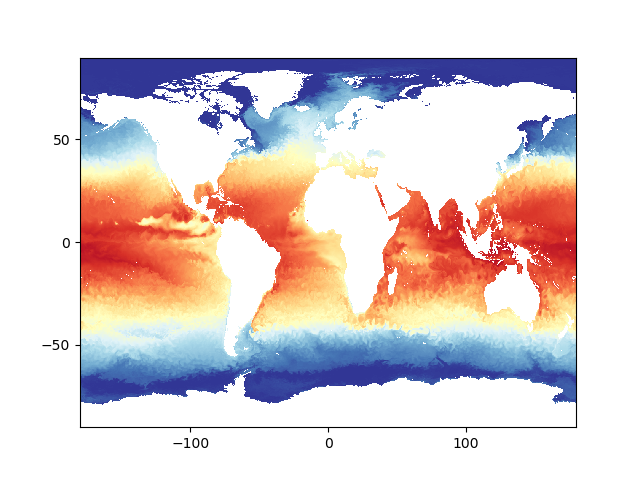

In [16]:
fig = plt.figure()
ax = plt.axes()

pyic.shade(lon[::10], lat[::10], t0i[::10,::10], ax=ax)

In [ ]:
## plot divergence selcection

In [46]:
# --- interpolate to rectgrid
ddnpz = np.load(fpath_ckdtree)
lon_002deg = ddnpz['lon']
lat_002deg = ddnpz['lat']

In [47]:
lon_reg_2 = [-75, -55]
lat_reg_2 = [33, 43]

# --- cut domain 2
i1r2 = (lon_002deg<lon_reg_2[0]).sum()
i2r2 = (lon_002deg<lon_reg_2[1]).sum()
j1r2 = (lat_002deg<lat_reg_2[0]).sum()
j2r2 = (lat_002deg<lat_reg_2[1]).sum()

lon_002deg_r2 = lon_002deg[i1r2:i2r2]
lat_002deg_r2 = lat_002deg[j1r2:j2r2]
#ro_002deg_r2= ro_002deg[j1r2:j2r2,i1r2:i2r2]

In [52]:
divo_002deg = pyic.apply_ckdtree(div_v[:], fpath_ckdtree, coordinates='clat clon', radius_of_influence=1.).reshape(lat_002deg.size, lon_002deg.size)
divo_002deg[divo_002deg==0.] = np.ma.masked
divo_002deg_r2= divo_002deg[j1r2:j2r2,i1r2:i2r2]

<IPython.core.display.Javascript object>


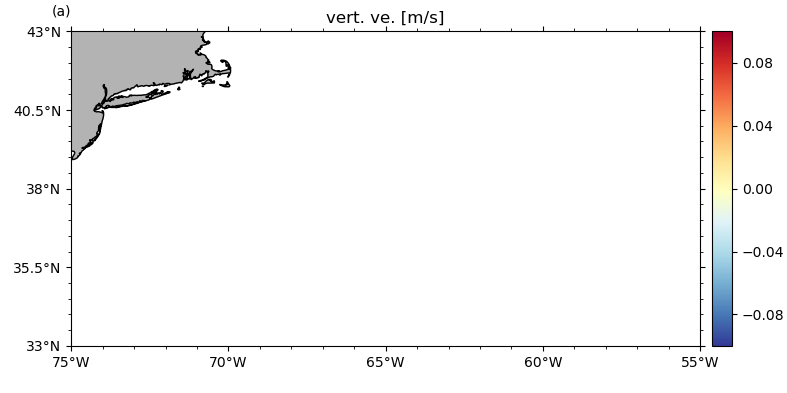

In [53]:
ccrs_proj = ccrs.PlateCarree()
# ccrs_proj = None
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.5, projection=ccrs_proj, fig_size_fac=2)
ii=-1
clim = 1.5

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon_002deg_r2, lat_002deg_r2, divo_002deg_r2, ax=ax, cax=cax, 
                transform=ccrs_proj, rasterized=False)
ax.set_title('vert. ve. [m/s]')


for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg_2, ylim=lat_reg_2)

In [56]:
del uo, vo 